In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime as dt

import pyfolio as pf 
import quantstats as qs



class Backtest_LongShort_SMA_Crossover_Strategy:
    def __init__(self,ticker,start_date,end_date,short_ma,long_ma):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.short_ma = short_ma
        self.long_ma = long_ma
        
        # Automatically executes the function upon object creation
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
    
    def fetch_data(self):
        self.df = yf.download(self.ticker,self.start_date,self.end_date)
        #print(self.df.head(50))
        
    def indicators(self):
        self.df['short_ma'] = self.df['Adj Close'].rolling(window = self.short_ma,min_periods = 1,center = False).mean()
        self.df['long_ma'] = self.df['Adj Close'].rolling(window = self.long_ma,min_periods = 1,center = False).mean()
        self.df['previous_short_ma'] = self.df['short_ma'].shift()
        self.df['previous_long_ma'] = self.df['long_ma'].shift()
        #self.df.dropna(inplace = True)
        
    def signals(self):
        self.df['signal'] = np.where((self.df['short_ma'] > self.df['long_ma']) & (self.df['previous_short_ma'] < self.df['previous_long_ma']),1,0)
        self.df['signal'] = np.where((self.df['short_ma'] < self.df['long_ma']) & (self.df['previous_short_ma'] > self.df['previous_long_ma']),-1,self.df['signal'])
        
    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace = 0,method = 'ffill')
        
    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Adj Close']/self.df['Adj Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        self.df.dropna(inplace = True)
        #print("Total_returns:",np.round(self.df['strategy_returns'].cumsum()[-1]),2)
        return self.df['strategy_returns'].cumsum()[-1]
    
    def analysis(self,asset,short,long):
        self.df[['short_ma','long_ma','position']].plot(grid = True,secondary_y = 'position',figsize = (15,10))
        plt.title('checking if positions are generated properly')
        #plt.savefig("mygraph1.png")
        file_name = f"{asset}_{short}_{long}"
        folder_name = asset
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize = (15,10),secondary_y = 'position')
        plt.title(f"Buy & hold' vs 'crossover strategy' cumulative returns for {asset}")
        
        plt.savefig(f"/home/deepa/Trading_strategies/Moving Average Crossover Strategy/Report/{file_name}.png")
        plt.show()
        qs.reports.basic(self.df['strategy_returns'])
        pf.create_simple_tear_sheet(self.df['strategy_returns'])
        
    def sort_returns(stock_list,short_ma_list,long_ma_list):
        end_date = dt.datetime(2023,11,5).date()
        start_date =end_date - dt.timedelta(days = 365*5)
        long_ma = []
        short_ma = []
        net_returns = []
        stock_names = []
        file_name = 'Indian_Instruments_Returns.xlsx'
        
        for stock in stock_list:
            for i in short_ma_list:
                for j in long_ma_list:
                    #print(f"For {i}-{j} time periods")
                    a = Backtest_LongShort_SMA_Crossover_Strategy(stock,start_date,end_date,i,j)
                    
                    long_ma.append(i)
                    short_ma.append(j)
                    net_returns.append(a.returns())
                    stock_names.append(stock)
                    a.analysis(a.ticker,i,j)
        results = pd.DataFrame({'stock_name':stock_names,'long_ma':long_ma,'short_ma':short_ma,'net_returns':net_returns})
        results = results.sort_values(by='net_returns',ascending=False)
        results.to_excel(file_name)
        print(results)
                        
class Backtest_LongShort_EMA_Crossover_Strategy(Backtest_LongShort_SMA_Crossover_Strategy):
    def indicators(self):
        self.short_ma = self.df['Adj Close'].ewm(span = self.short_ma,adjust=False).mean()
        self.long_ma = self.df['Adj Close'].ewm(span=self.long_ma,adjust=False).mean()
        self.df['previous_short_ma'] = self.df['short_ma'].shift()
        self.df['previous_long_ma'] = self.df['long_ma'].shift()
        self.df.dropna(inplace=True)
        
                       
        
    # main function
def main():
    
    # end_date = dt.datetime(2023,11,5).date()
    # start_date =end_date - dt.timedelta(days = 365*5)
    # nifty_10_20 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,10,20)
    # nifty_5_20 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,5,20)
    # nifty_5_10 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,5,10)
    # nifty_5_50 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,5,50)
    # nifty_10_50 = Backtest_LongShort_SMA_Crossover_Strategy('^NSEI',start_date,end_date,10,50)
    
    # nifty_10_20.analysis()
    # nifty_5_20.analysis()
    # nifty_5_10.analysis()
    # nifty_5_50.analysis()
    # nifty_10_50.analysis()
    
    # Define a list of assets
    stock_list = [  #'BAJFINANCE.NS',
                    # 'TRENT.NS',
                    # 'BPCL.NS'
                    # 'BRITANNIA.NS',
                     'COALINDIA.NS'
                    # 'DRREDDY.NS',
                    # 'GAIL.NS',
                    #'ASIANPAINT.NS',
                    # 'ASHOKLEY.NS',
                    #'L&TFH.NS',
                    # 'TCS.NS',
                    # 'LUPIN.NS',
                    # 'CUMMINSIND.NS',
                    #'COFORGE.NS'                   
                ]
    short_ma_list = [10]
    long_ma_list = [100]
    #Backtest_LongShort_SMA_Crossover_Strategy.sort_returns(stock_list,short_ma_list,long_ma_list)
    Backtest_LongShort_EMA_Crossover_Strategy.sort_returns(stock_list,short_ma_list,long_ma_list)

        
if __name__ == '__main__':
    main()
        
        
        
    
        
        
    
        

        
    

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-11-06  281.100006  281.850006  276.100006  277.299988  229.822296   
2018-11-07  281.000000  281.000000  278.799988  280.049988  232.101471   
2018-11-09  279.000000  279.700012  275.899994  277.250000  229.780869   
2018-11-12  277.799988  278.200012  273.250000  273.850006  226.963028   
2018-11-13  273.950012  277.899994  273.149994  276.850006  229.449356   

              Volume  
Date                  
2018-11-06   9766345  
2018-11-07    957139  
2018-11-09  15034793  
2018-11-12   7047500  
2018-11-13   6700755  
            2018-11-06 00:00:00  2018-11-07 00:00:00  2018-11-09 00:00:00  \
Date                                                                        
2023-10-20                  NaN                  NaN                  NaN   
2023-10-23          

/tmp/ipykernel_27659/638655919.py:139: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


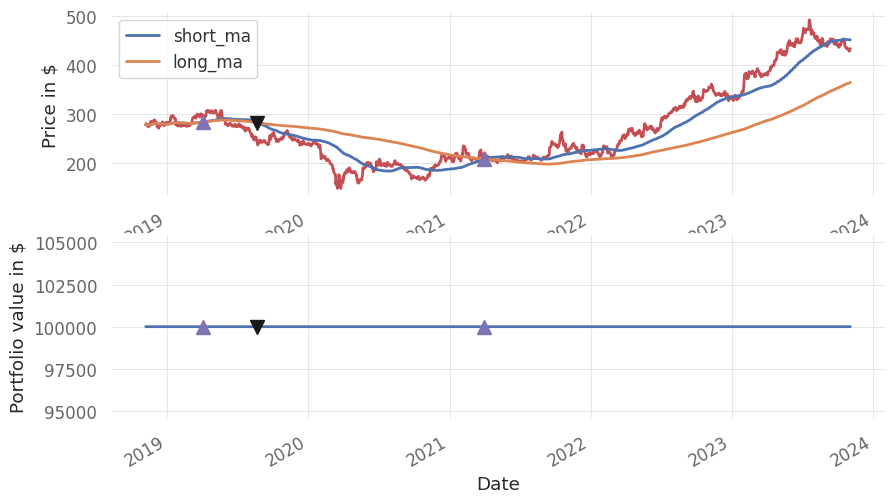

In [28]:
# ma_cross.py

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
import quantstats as qs
import pyfolio as pf

from pandas_datareader import DataReader
from backtest import Strategy, Portfolio

class MovingAverageCrossoverStrategy(Strategy):
    """    
    Requires:
    symbol - A stock symbol on which to form a strategy on.
    bars - A DataFrame of bars for the above symbol.
    short_window - Lookback period for short moving average.
    long_window - Lookback period for long moving average.
    """
    
    def __init__(self,symbol,bars,short_window=100,long_window=400):
        self.symbol = symbol
        self.bars = bars
        self.short_window = short_window
        self.long_window = long_window
        
        
    def generate_signals(self):
        """Returns the DataFrame of symbols containing the signals
        to go long, short or hold (1, -1 or 0)."""
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0
        
        # Create a set of short and long simple moving averages
        signals['short_ma'] = self.bars['Close'].rolling(window = self.short_window, min_periods = 1 ).mean()
        signals['long_ma'] = self.bars['Close'].rolling(window = self.long_window,min_periods = 1).mean()
        
        # Create a 'signal' (invested or not invested) when the short moving average crosses the long
        # moving average, but only for the period greater than the shortest moving average window
        signals['signal'][self.short_window:] = np.where(signals['short_ma'][self.short_window:]>signals['long_ma'][self.short_window:],1.0,0.0) 
        
        # Take the difference of the signals in order to generate actual trading orders
        signals['positions'] = signals['signal'].diff()
        
        return signals
        
        
        #return super().generate_signals()    

class MarketOnClosePortfolio(Portfolio):
    '''
    Encapsulates the portfolio of positions that is based on the signals that is provided by the strategy class
    Requires:
    symbol - A stock symbol which forms the basis of portfolio
    bar - A dataframe of bars for a symbol set
    signals - Dataframe of signals that inculde (1,0,-1) for long, hold and short respectively
    initial_investment - The amount in cash at the start of the portfolio
    '''
    def __init__(self,symbol,bars,signals,initial_investment= 100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_investment = float(initial_investment)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions['AAPL'] = 100*self.signals['signal']
        return positions
    
    def backtest_portfolio(self):
        portfolio = self.positions*self.bars['Close']
        pos_diff = self.positions.diff()
        cash_diff = pos_diff * self.bars['Close']
        portfolio['cash'] = self.initial_investment - cash_diff.sum(axis=1).cumsum()
        portfolio['holdings'] = (self.positions * self.bars['Close']).sum(axis=1)
        
        portfolio['total'] = portfolio['cash']+portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        # portfolio['returns'].plot(figsize=(12,8),grid=True)
        # plt.show()
        return portfolio
        
        
if __name__ == "__main__":
    symbol = "ITC.NS"
    end_date = dt.datetime(2023,11,5).date()
    start_date =end_date - dt.timedelta(days = 365*5)
    bars = yf.download(symbol, start_date, end_date)
    print(bars.head())
    # Create a Moving Average Cross Strategy instance with a short moving
    # average window of 100 days and a long window of 400 days
    mac = MovingAverageCrossoverStrategy(symbol,bars,short_window = 100,long_window = 400)
    signals = mac.generate_signals()
    
    # Create a portfolio of AAPL, with $100,000 initial capital
    portfolio = MarketOnClosePortfolio(symbol,bars,signals,initial_investment = 100000.0)
    returns = portfolio.backtest_portfolio()
    print(returns.tail(10))
        
    
    
    # Plot two charts to assess trades and equity curve
    fig = plt.figure()
    fig.patch.set_facecolor('white')     # Set the outer colour to white
    ax1 = fig.add_subplot(211, ylabel = 'Price in $')
      
    # Plot the AAPL closing price overlaid with the moving averages
    bars['Close'].plot(ax=ax1, color='r', lw=2.)
    signals[['short_ma', 'long_ma']].plot(ax=ax1, lw=2.)

    # Plot the "buy" trades against AAPL
    ax1.plot(signals.index[signals.positions == 1.0], 
             signals.short_ma[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the "sell" trades against AAPL
    ax1.plot(signals.index[signals.positions == -1.0], 
             signals.short_ma[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the equity curve in dollars
    ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
    returns['total'].plot(ax=ax2, lw=2.)

    # Plot the "buy" and "sell" trades against the equity curve
    ax2.plot(returns.index[signals.positions == 1.0], 
             returns.total[signals.positions == 1.0],
             '^', markersize=10, color='m')
    ax2.plot(returns.index[signals.positions == -1.0], 
             returns.total[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the figure
    fig.savefig('output_figure.png')
    fig.show()
    
    